# Linear fit DeepEnsemble

## The dataset: simple linefit

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [5]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [6]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [7]:
loss_type = 'var_loss'
# options are 'no_var_loss' or 'var_loss'
# var_loss is a gaussian negative log likelihood option that incorporates a variance term (for aleatoric uncertainty)

## Generate line data
Unlike in the case of inference, here we need to upfront generate a dataframe and replicate a bunch of columns. We will generate using random draws from distributions that are similar to the priors in the case of the likelihood-based inference analysis.

In [8]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma)#, size = len(x)) 
    return m * x_data + b + ε

In [27]:
x_data = np.linspace(0, 100, 101)

length_df = 10
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

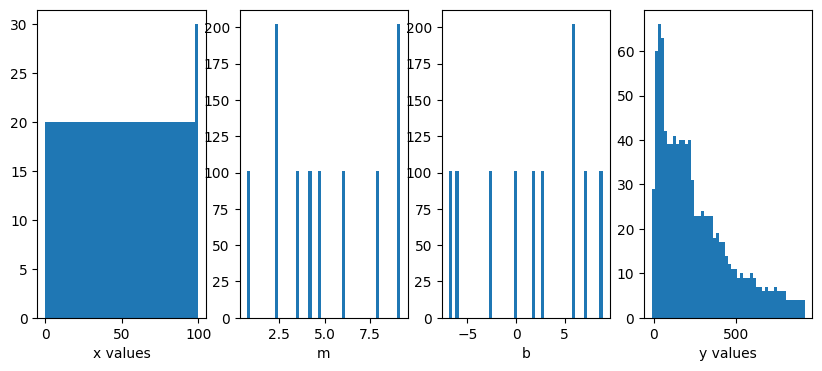

In [33]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [46]:
# we need to normalize everything
inputmin = np.min(inputs, axis = 0)
inputmax = np.max(inputs, axis = 0)#, axis = 0)
outputmin = np.min(ys)
outputmax = np.max(ys)

norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys - outputmin) / (outputmax - outputmin)
print('input min, max', inputmin, inputmax, 'output min, max', outputmin, outputmax)

input min, max [ 2.44495444e-03 -3.27582046e+00 -3.75373054e+01  7.32807181e-03] [99.99622469  5.27533417 39.81101494 37.711146  ] output min, max -298.14785858427894 404.1617999106565


<Figure size 640x480 with 0 Axes>

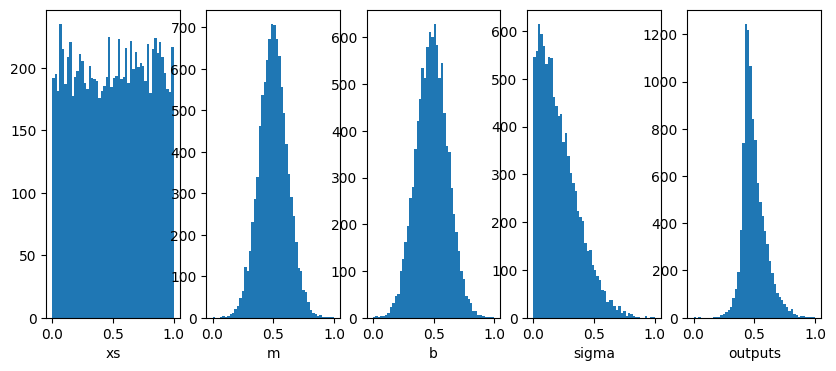

In [47]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(151)
ax0.hist(norm_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(152)
ax1.hist(norm_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(153)
ax2.hist(norm_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(154)
ax3.hist(norm_inputs[:,3], bins=50)
ax3.set_xlabel('sigma')
ax4 = fig.add_subplot(155)
ax4.hist(norm_outputs[:], bins=50)
ax4.set_xlabel('outputs')
plt.show()

In [ ]:
## Awesome, they are now normalized 0 - 1 but have the same distribution as before

(9000, 4) (9000,)
(4,)


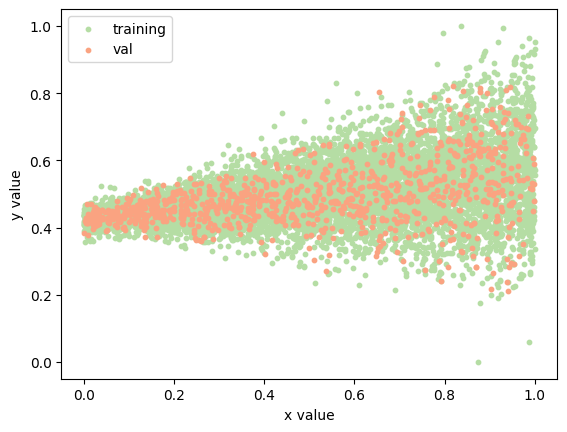

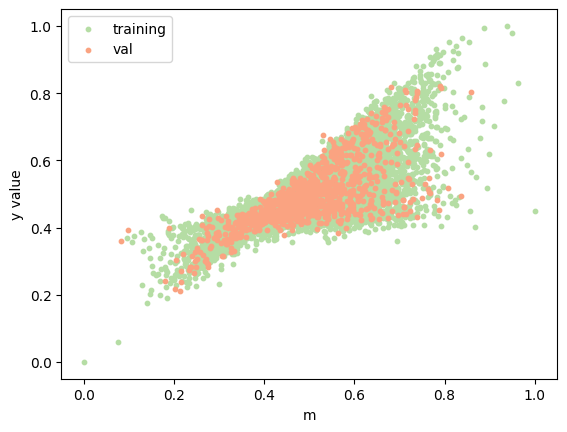

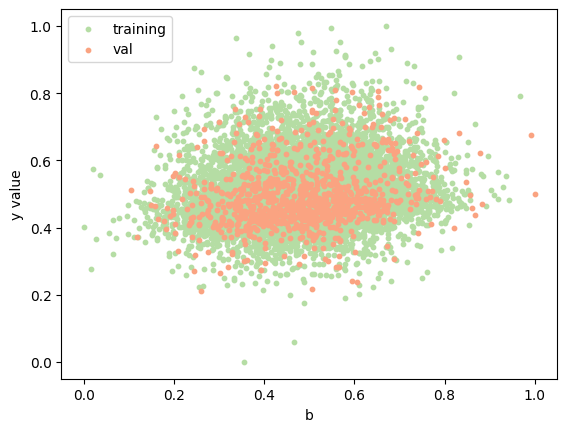

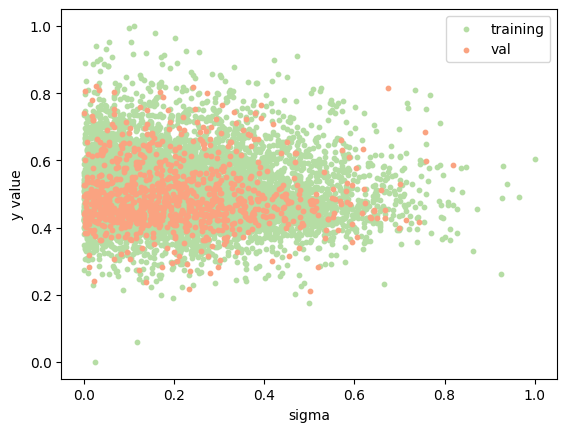

'\nSTOP\n#\n\nscaler = StandardScaler()\nscaler.fit(data)\nStandardScaler()\n>>> print(scaler.mean_)\n[0.5 0.5]\n>>> print(scaler.transform(data))\n\nx_scaler, x_train, x_val = StandardScaler(x_train, x_val)\ny_scaler, y_train, y_val = StandardScaler(y_train, y_val)\n'

In [12]:
# prepare the training, validation, and test set split:

val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_inputs, norm_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,3], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,3], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('sigma')
plt.ylabel('y value')
plt.show()



'''
STOP
#

scaler = StandardScaler()
scaler.fit(data)
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))

x_scaler, x_train, x_val = StandardScaler(x_train, x_val)
y_scaler, y_train, y_val = StandardScaler(y_train, y_val)
'''

In [13]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (9000, 4)


In [14]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if loss_type == 'no_var_loss':
    model = models.de_no_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.MSELoss(reduction="mean")
else:
    model = models.de_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.GaussianNLLLoss(full=False, eps=1e-06, reduction="mean")
#nn.MSELoss(reduction = "mean")

[INFO] initializing the gal model...


In [15]:
print(model)

de_var(
  (ln_1): Linear(in_features=4, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=2, bias=True)
)


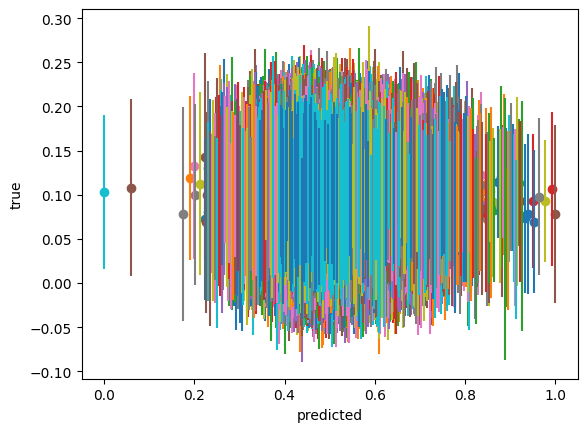

In [16]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    
    if loss_type == 'no_var_loss':
        print(np.shape(y), np.shape(pred))
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('predicted')
plt.ylabel('true')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


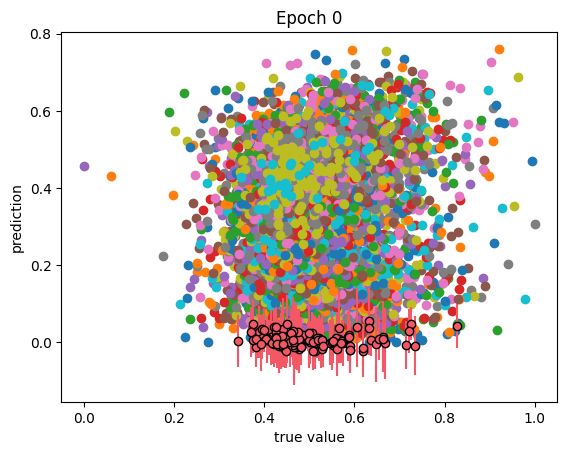

new best mse -1.6008025407791138 in epoch 0
epoch 1 0.0
new best mse -1.979356050491333 in epoch 1
epoch 2 0.01
epoch 3 0.01
epoch 4 0.01
epoch 5 0.01


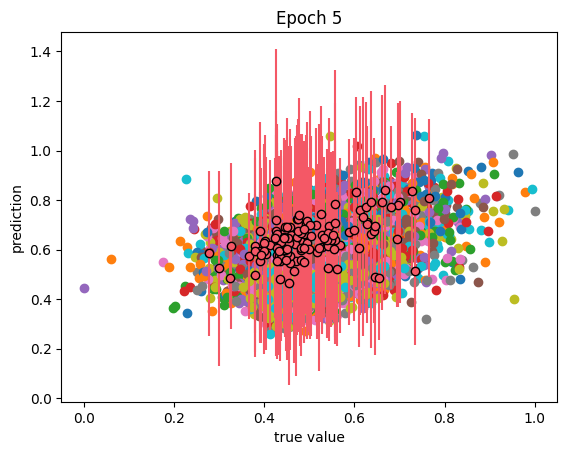

epoch 6 0.01
epoch 7 0.02
epoch 8 0.02
epoch 9 0.02
epoch 10 0.03


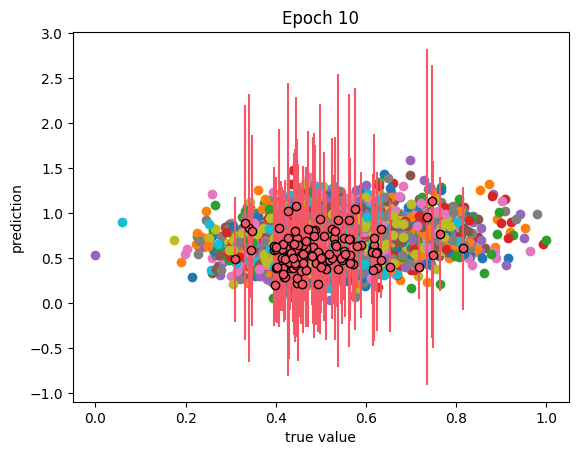

epoch 11 0.03
epoch 12 0.03
epoch 13 0.03
epoch 14 0.04
epoch 15 0.04


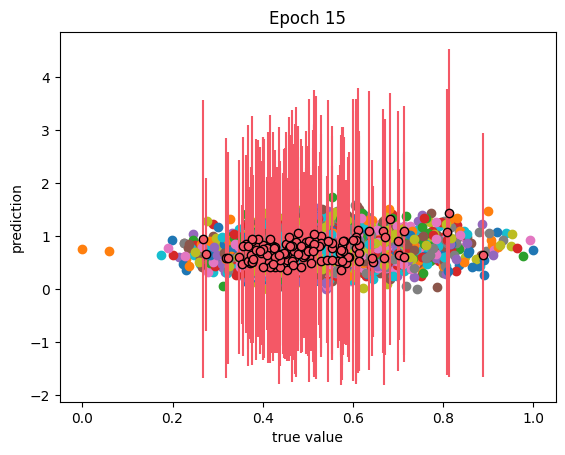

epoch 16 0.04
epoch 17 0.04
epoch 18 0.04
epoch 19 0.05
epoch 20 0.05


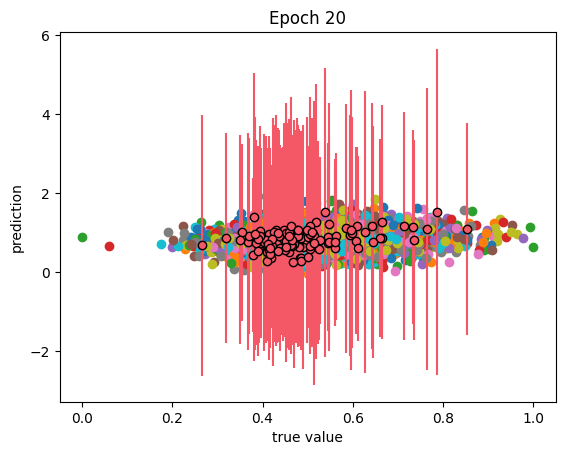

epoch 21 0.05
epoch 22 0.06
epoch 23 0.06
epoch 24 0.06
epoch 25 0.06


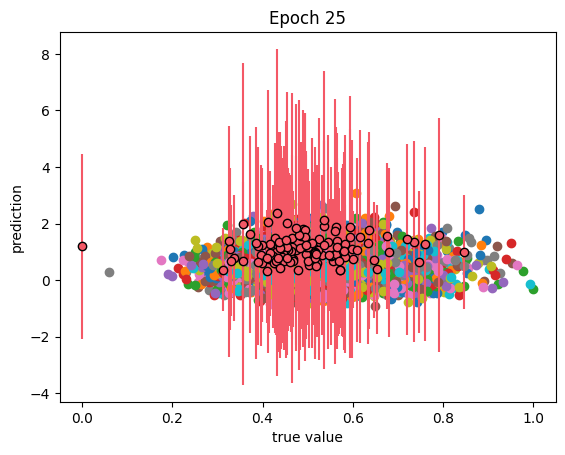

epoch 26 0.07
epoch 27 0.07
epoch 28 0.07
epoch 29 0.07
epoch 30 0.07


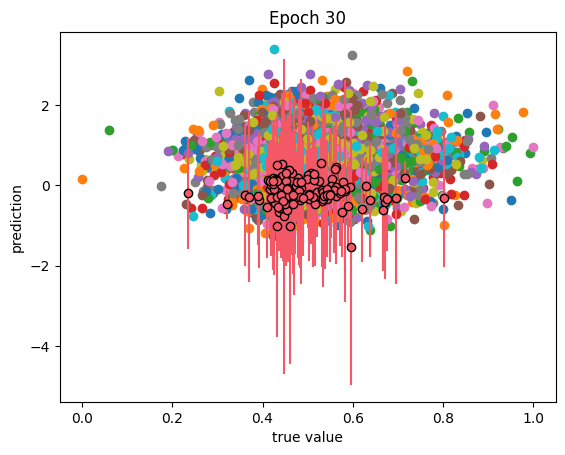

epoch 31 0.08
epoch 32 0.08
epoch 33 0.08
epoch 34 0.09
epoch 35 0.09


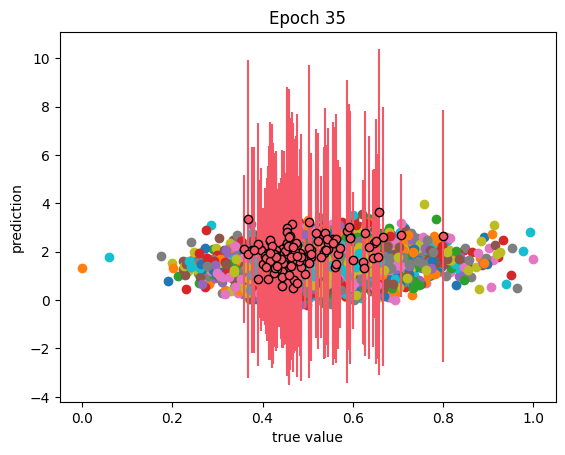

epoch 36 0.09
epoch 37 0.09
epoch 38 0.1
epoch 39 0.1
epoch 40 0.1


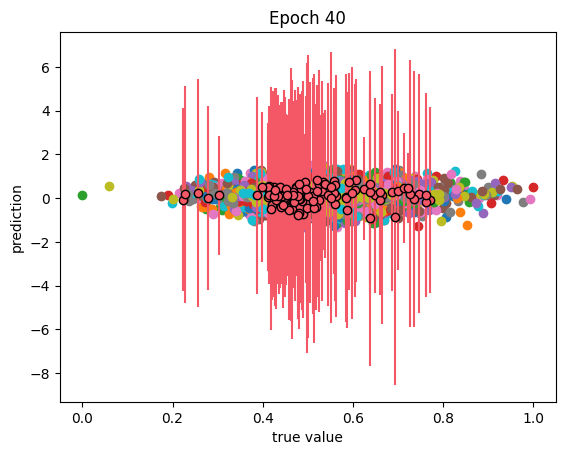

epoch 41 0.1
epoch 42 0.1
epoch 43 0.11
epoch 44 0.11
epoch 45 0.11


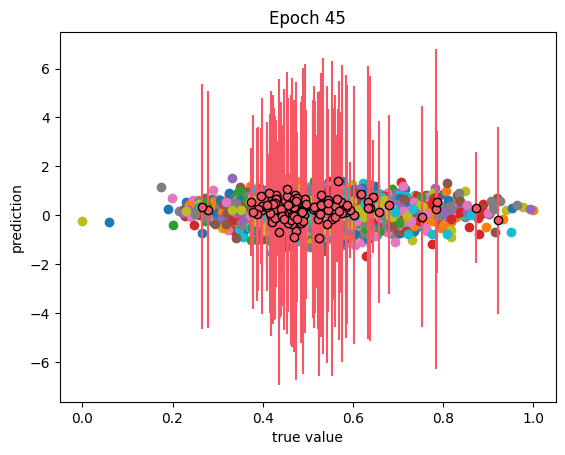

epoch 46 0.12
epoch 47 0.12
epoch 48 0.12
epoch 49 0.12
epoch 50 0.12


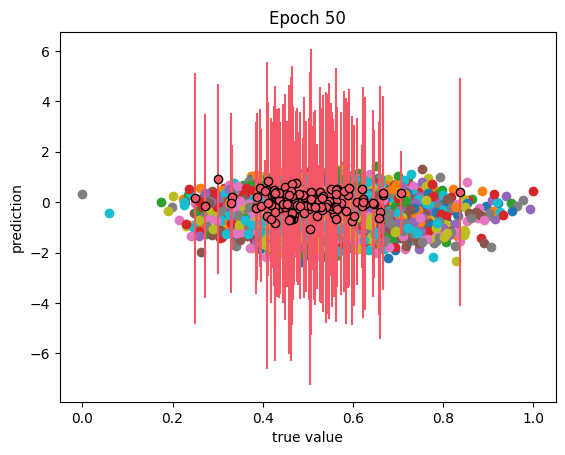

epoch 51 0.13
epoch 52 0.13
epoch 53 0.13
epoch 54 0.14
epoch 55 0.14


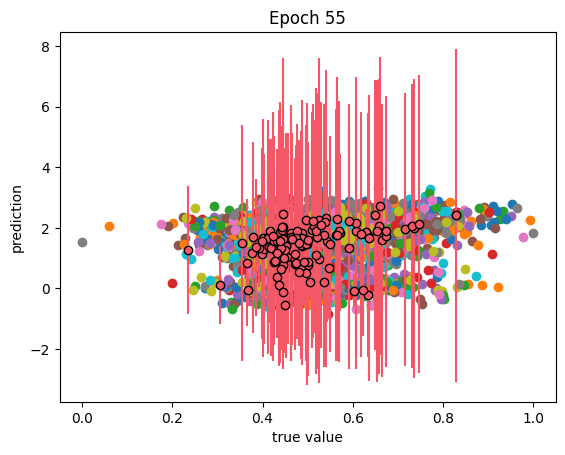

epoch 56 0.14
epoch 57 0.14
epoch 58 0.14
epoch 59 0.15
epoch 60 0.15


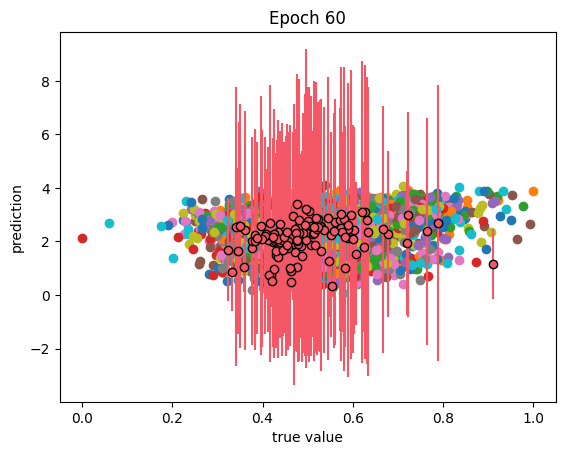

epoch 61 0.15
epoch 62 0.15
epoch 63 0.16
epoch 64 0.16
epoch 65 0.16


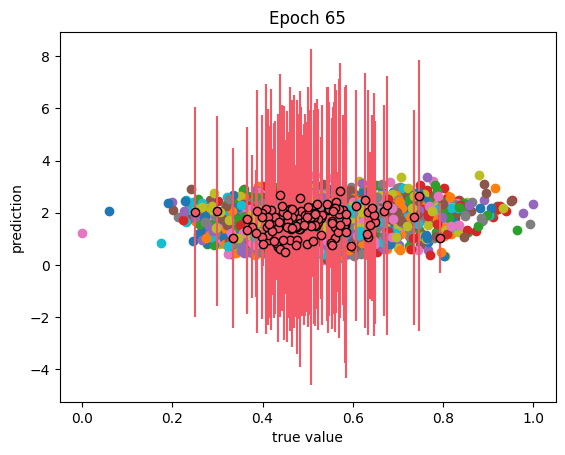

epoch 66 0.17
epoch 67 0.17
epoch 68 0.17
epoch 69 0.17
epoch 70 0.17


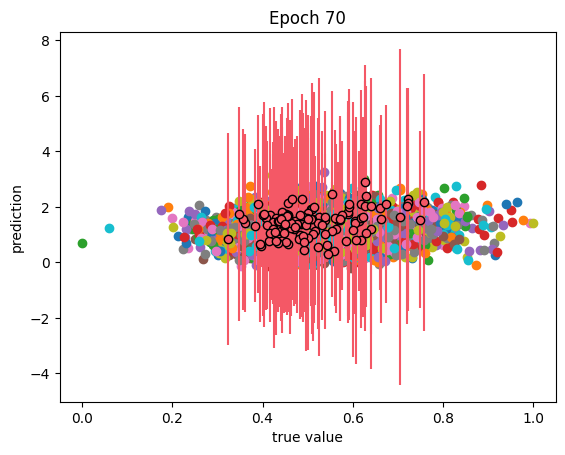

epoch 71 0.18
epoch 72 0.18
epoch 73 0.18
epoch 74 0.18
epoch 75 0.19


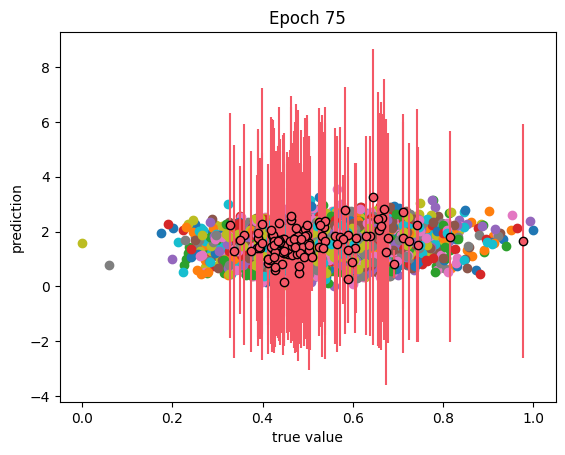

epoch 76 0.19
epoch 77 0.19
epoch 78 0.2
epoch 79 0.2
epoch 80 0.2


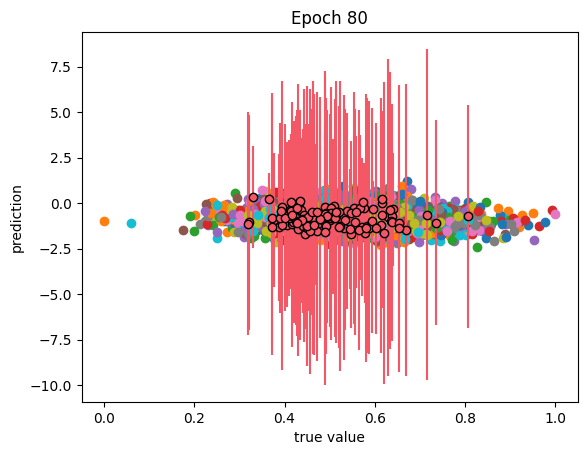

epoch 81 0.2
epoch 82 0.2
epoch 83 0.21
epoch 84 0.21
epoch 85 0.21


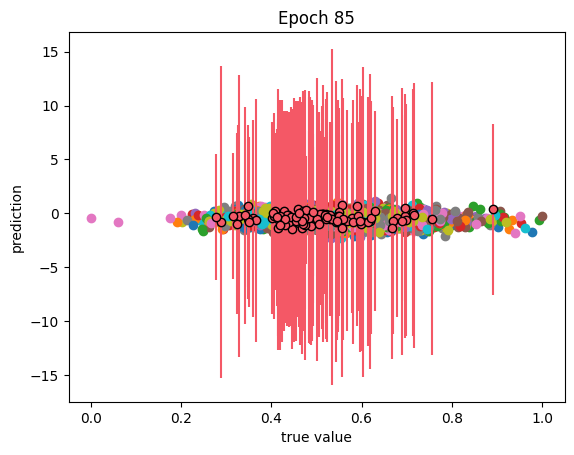

epoch 86 0.21
epoch 87 0.22
epoch 88 0.22
epoch 89 0.22
epoch 90 0.23


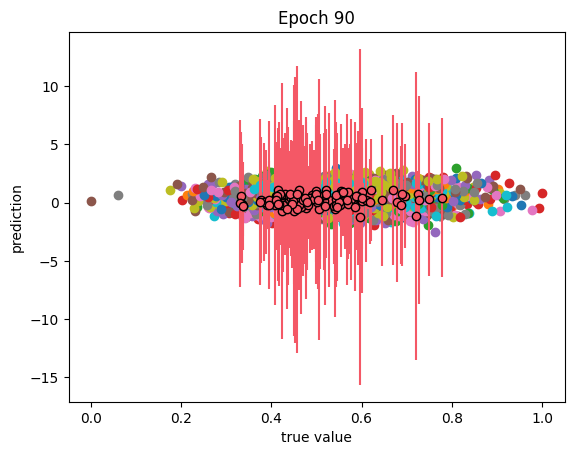

epoch 91 0.23
epoch 92 0.23
epoch 93 0.23
epoch 94 0.23
epoch 95 0.24


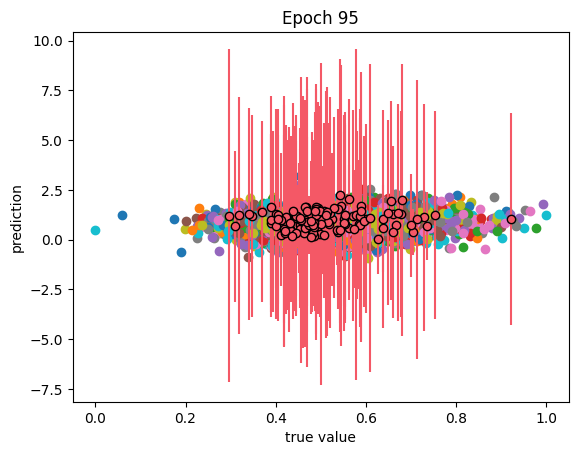

epoch 96 0.24
epoch 97 0.24
epoch 98 0.24
epoch 99 0.25
epoch 100 0.25


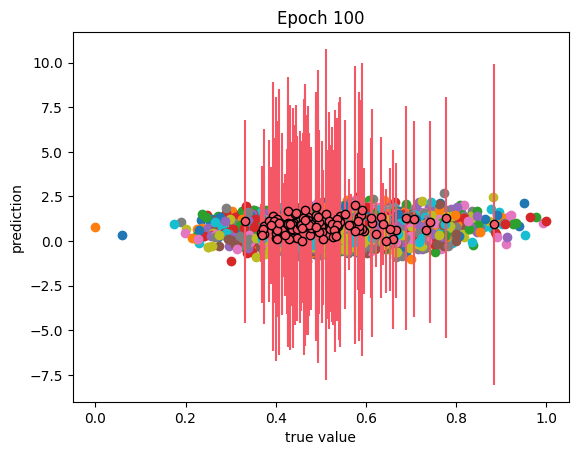

epoch 101 0.25
epoch 102 0.26
epoch 103 0.26
epoch 104 0.26
epoch 105 0.26


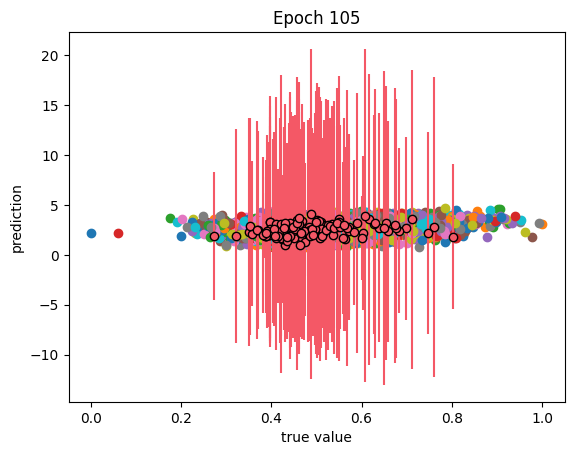

epoch 106 0.27
epoch 107 0.27
epoch 108 0.27
epoch 109 0.27
epoch 110 0.28


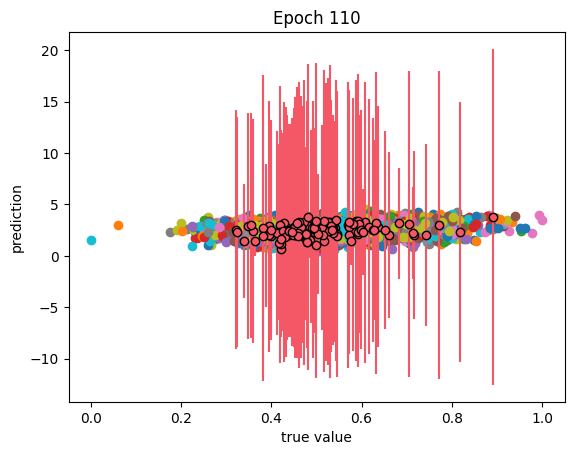

epoch 111 0.28
epoch 112 0.28
epoch 113 0.28
epoch 114 0.28
epoch 115 0.29


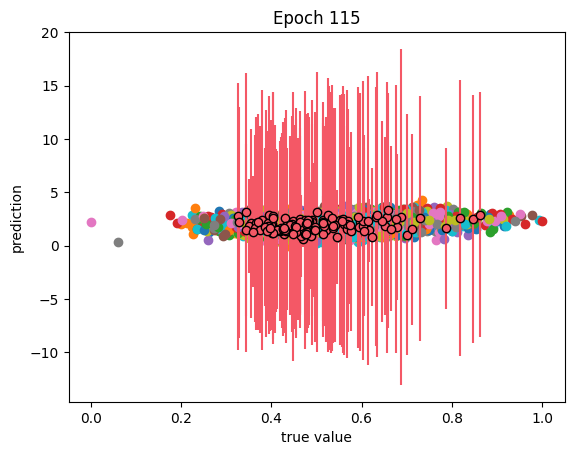

epoch 116 0.29
epoch 117 0.29
epoch 118 0.29
epoch 119 0.3
epoch 120 0.3


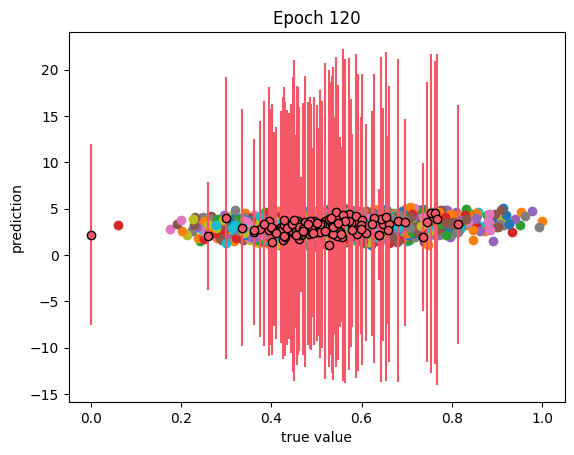

epoch 121 0.3
epoch 122 0.3
epoch 123 0.31
epoch 124 0.31
epoch 125 0.31


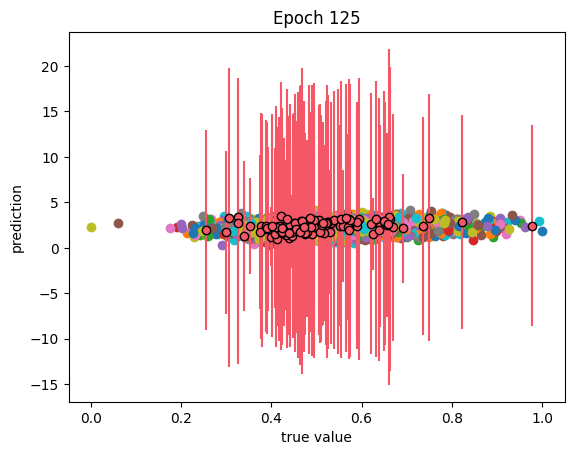

epoch 126 0.32
epoch 127 0.32
epoch 128 0.32
epoch 129 0.32
epoch 130 0.33


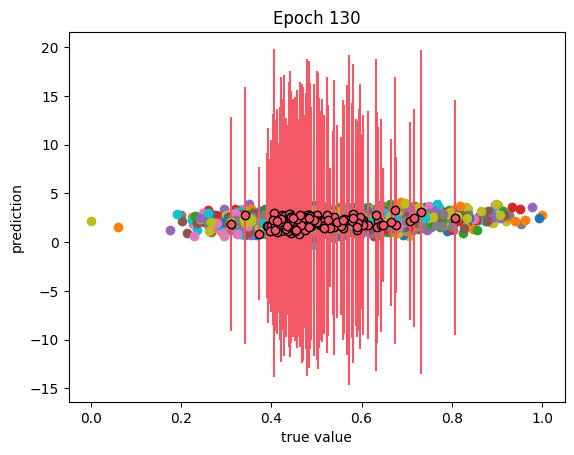

epoch 131 0.33
epoch 132 0.33
epoch 133 0.33
epoch 134 0.34
epoch 135 0.34


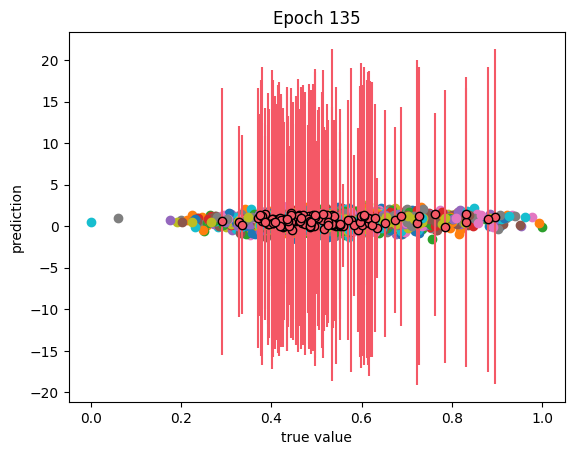

epoch 136 0.34
epoch 137 0.34
epoch 138 0.34
epoch 139 0.35
epoch 140 0.35


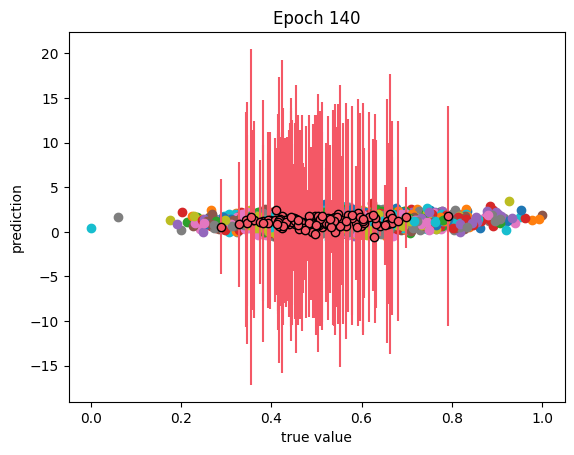

epoch 141 0.35
epoch 142 0.35
epoch 143 0.36
epoch 144 0.36
epoch 145 0.36


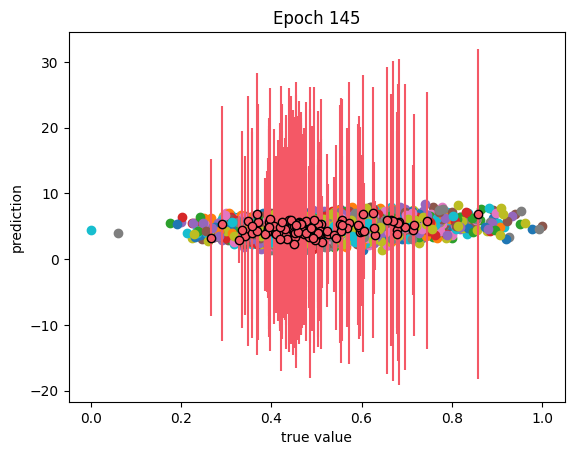

epoch 146 0.36
epoch 147 0.37
epoch 148 0.37
epoch 149 0.37
epoch 150 0.38


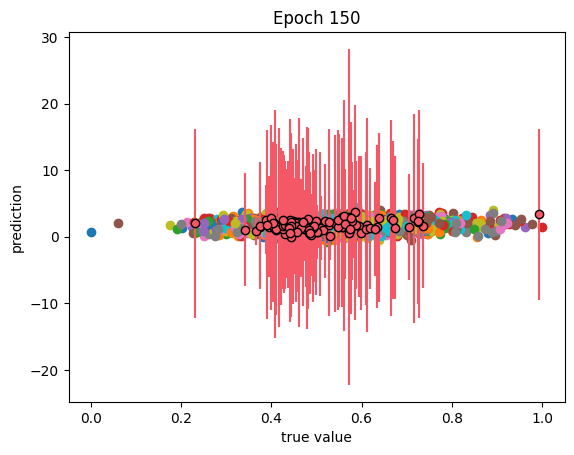

epoch 151 0.38
epoch 152 0.38
epoch 153 0.38
epoch 154 0.39
epoch 155 0.39


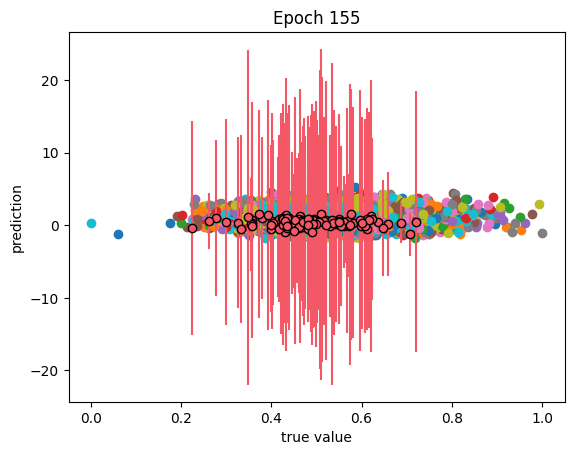

epoch 156 0.39
epoch 157 0.39
epoch 158 0.4
epoch 159 0.4
epoch 160 0.4


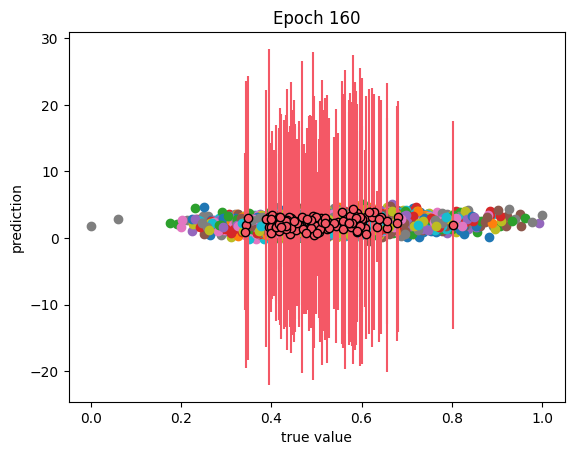

epoch 161 0.4
epoch 162 0.41
epoch 163 0.41
epoch 164 0.41
epoch 165 0.41


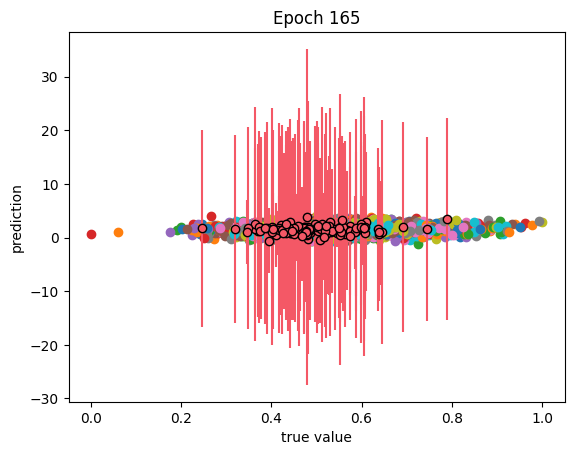

epoch 166 0.41
epoch 167 0.42
epoch 168 0.42
epoch 169 0.42
epoch 170 0.42


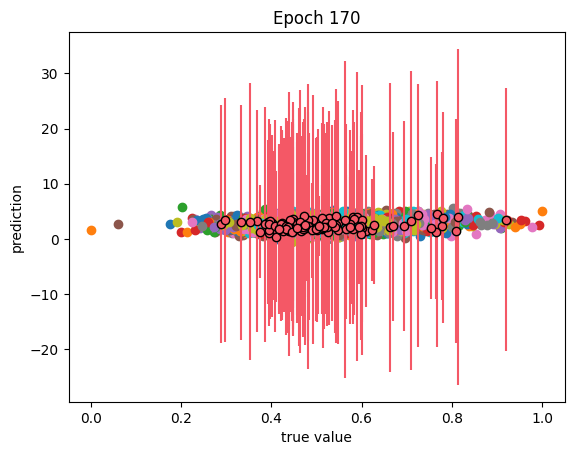

epoch 171 0.43
epoch 172 0.43
epoch 173 0.43
epoch 174 0.43
epoch 175 0.44


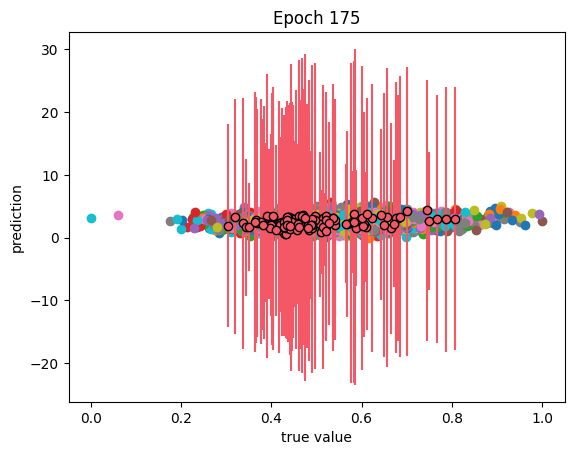

epoch 176 0.44
epoch 177 0.44
epoch 178 0.45
epoch 179 0.45
epoch 180 0.45


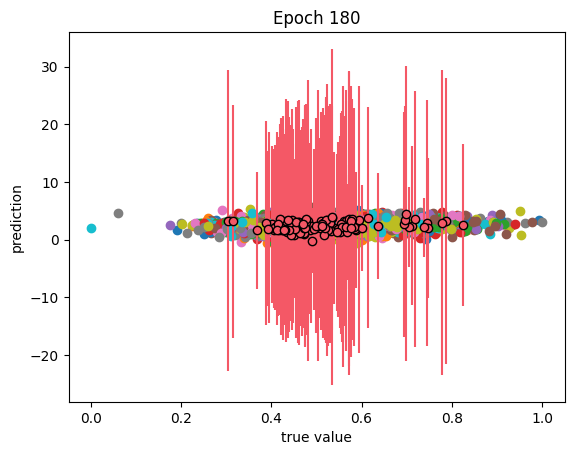

epoch 181 0.45
epoch 182 0.46
epoch 183 0.46
epoch 184 0.46
epoch 185 0.46


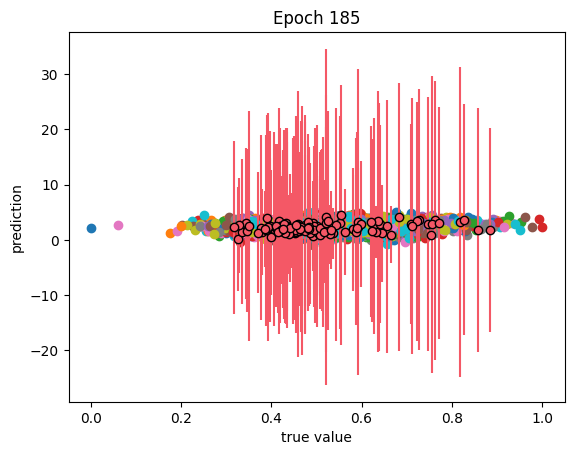

epoch 186 0.47
epoch 187 0.47
epoch 188 0.47
epoch 189 0.47
epoch 190 0.47


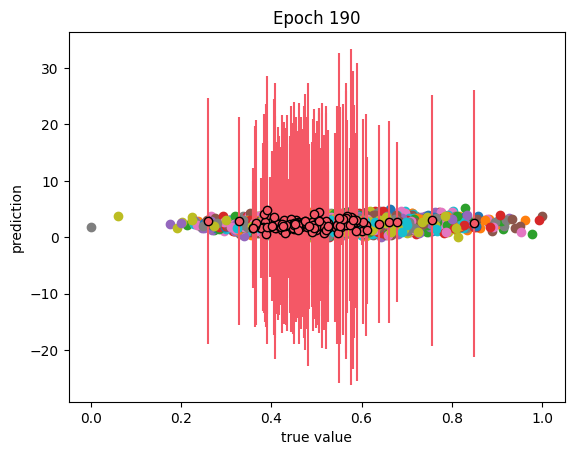

epoch 191 0.48
epoch 192 0.48
epoch 193 0.48
epoch 194 0.48
epoch 195 0.49


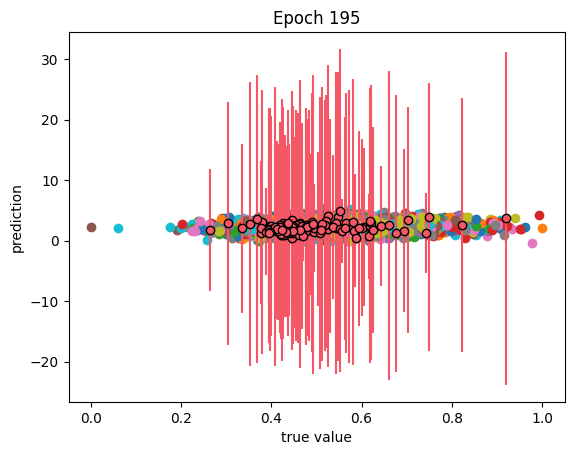

epoch 196 0.49
epoch 197 0.49
epoch 198 0.49
epoch 199 0.5
epoch 200 0.5


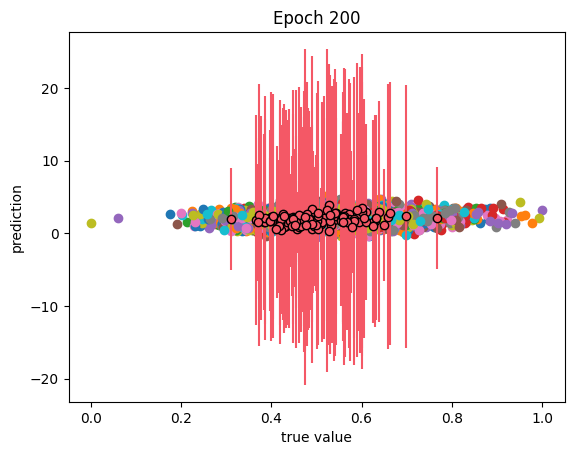

epoch 201 0.5
epoch 202 0.51
epoch 203 0.51
epoch 204 0.51
epoch 205 0.51


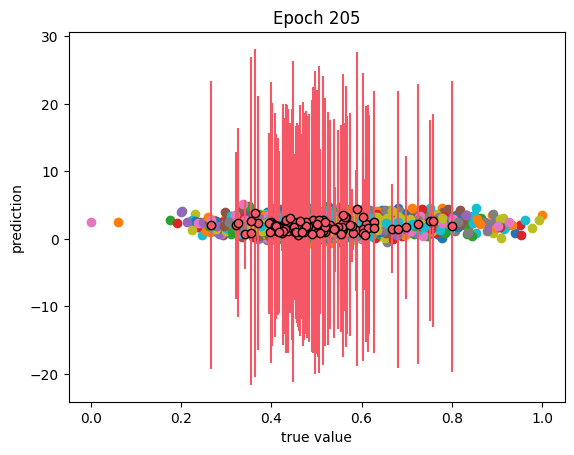

epoch 206 0.52
epoch 207 0.52
epoch 208 0.52
epoch 209 0.52
epoch 210 0.53


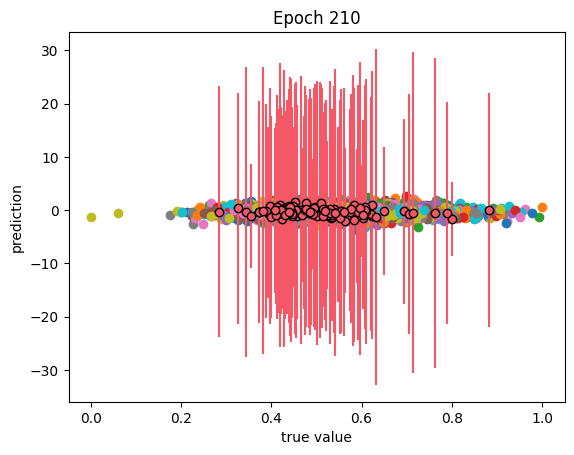

epoch 211 0.53
epoch 212 0.53
epoch 213 0.53
epoch 214 0.54
epoch 215 0.54


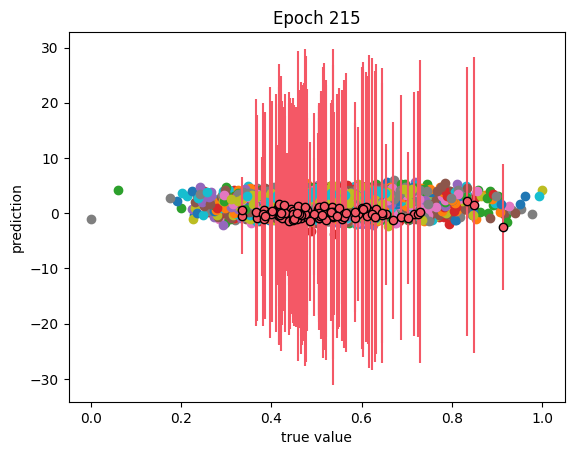

epoch 216 0.54
epoch 217 0.54
epoch 218 0.55
epoch 219 0.55
epoch 220 0.55


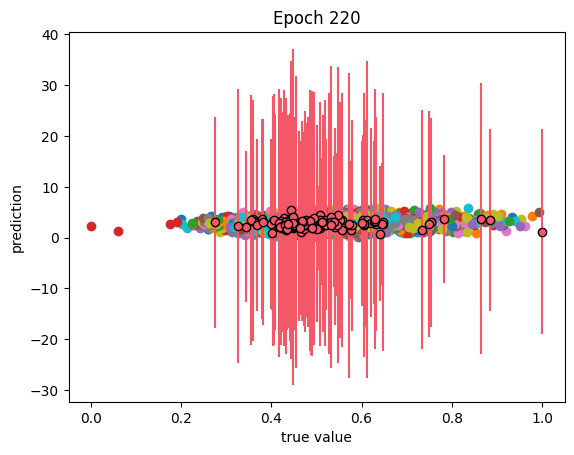

epoch 221 0.55
epoch 222 0.56
epoch 223 0.56
epoch 224 0.56
epoch 225 0.56


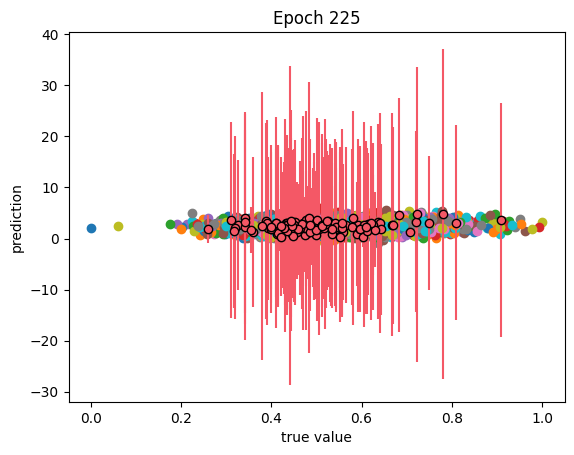

epoch 226 0.56
epoch 227 0.57
epoch 228 0.57
epoch 229 0.57
epoch 230 0.57


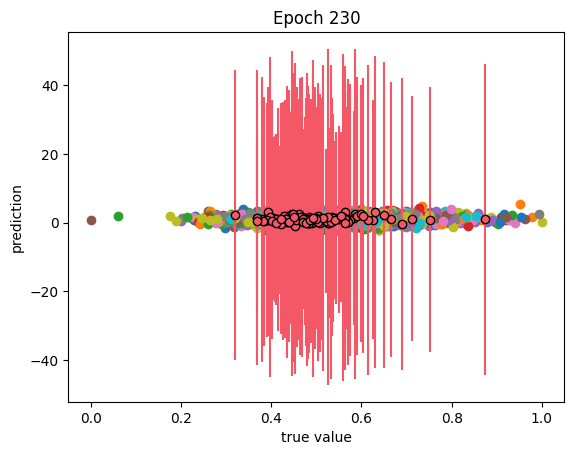

epoch 231 0.58
epoch 232 0.58
epoch 233 0.58
epoch 234 0.58
epoch 235 0.59


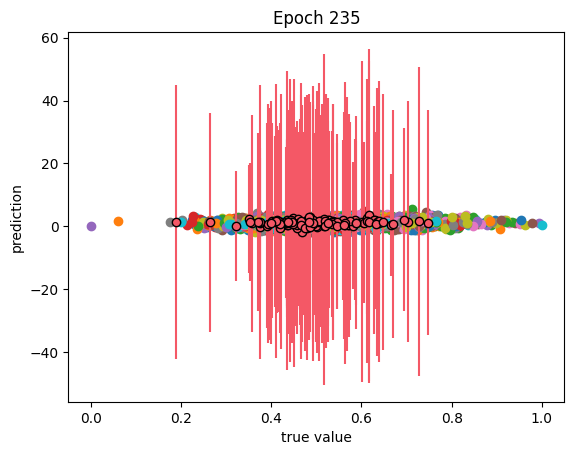

epoch 236 0.59
epoch 237 0.59
epoch 238 0.59
epoch 239 0.6
epoch 240 0.6


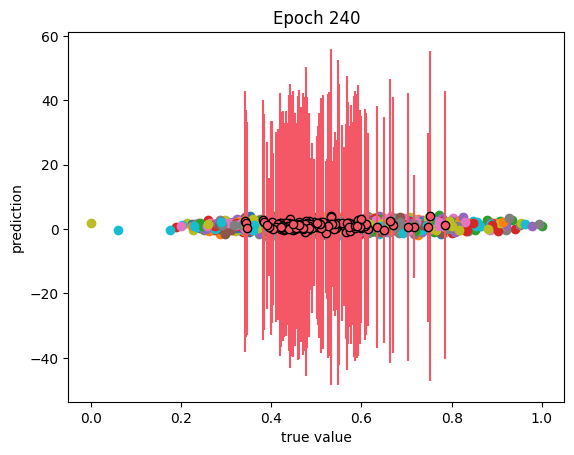

epoch 241 0.6
epoch 242 0.6
epoch 243 0.61
epoch 244 0.61
epoch 245 0.61


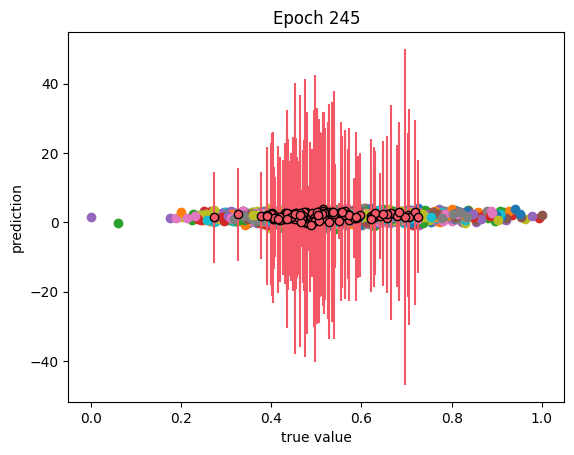

epoch 246 0.61
epoch 247 0.62
epoch 248 0.62
epoch 249 0.62
epoch 250 0.62


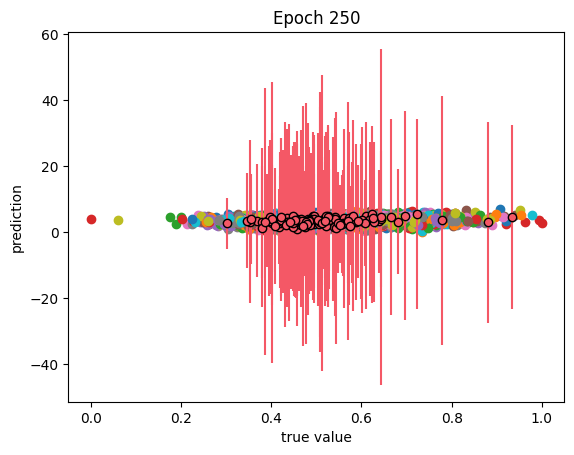

epoch 251 0.63
epoch 252 0.63
epoch 253 0.63
epoch 254 0.64
epoch 255 0.64


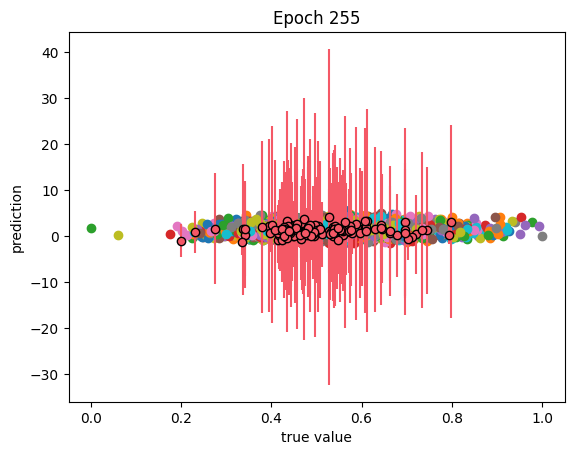

epoch 256 0.64
epoch 257 0.64
epoch 258 0.65
epoch 259 0.65
epoch 260 0.65


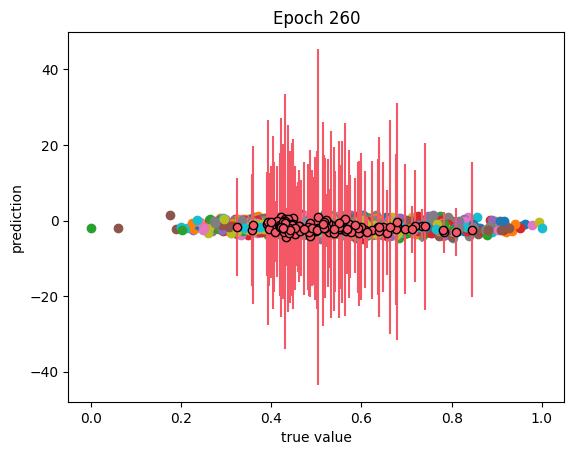

epoch 261 0.65
epoch 262 0.66
epoch 263 0.66
epoch 264 0.66
epoch 265 0.66


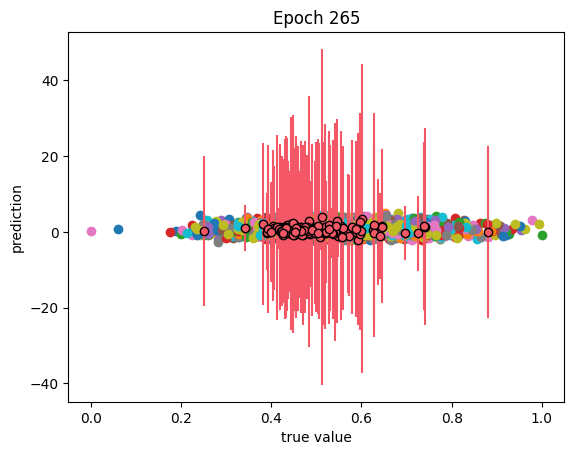

epoch 266 0.67
epoch 267 0.67
epoch 268 0.67
epoch 269 0.67
epoch 270 0.68


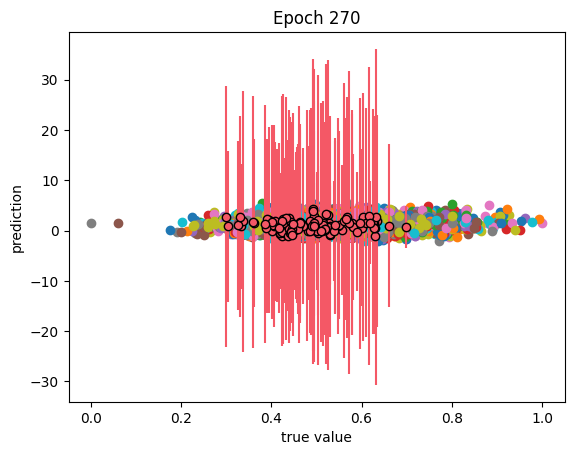

epoch 271 0.68
epoch 272 0.68
epoch 273 0.68
epoch 274 0.69
epoch 275 0.69


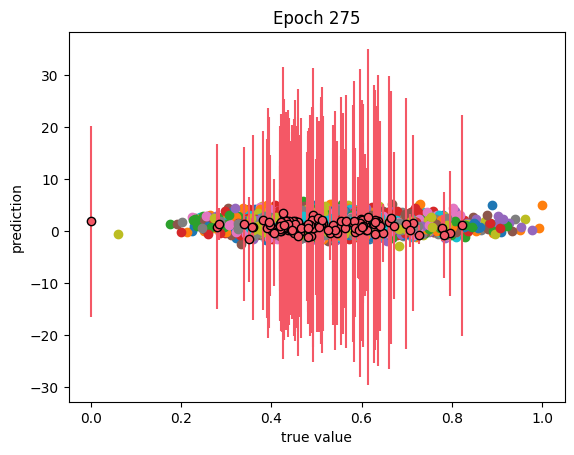

epoch 276 0.69
epoch 277 0.69
epoch 278 0.69
epoch 279 0.7
epoch 280 0.7


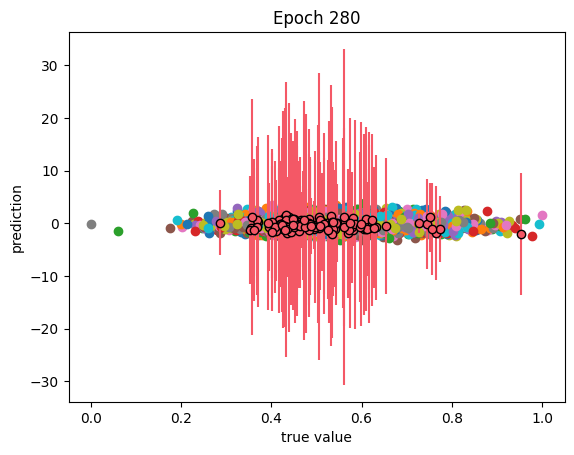

epoch 281 0.7
epoch 282 0.7
epoch 283 0.71
epoch 284 0.71
epoch 285 0.71


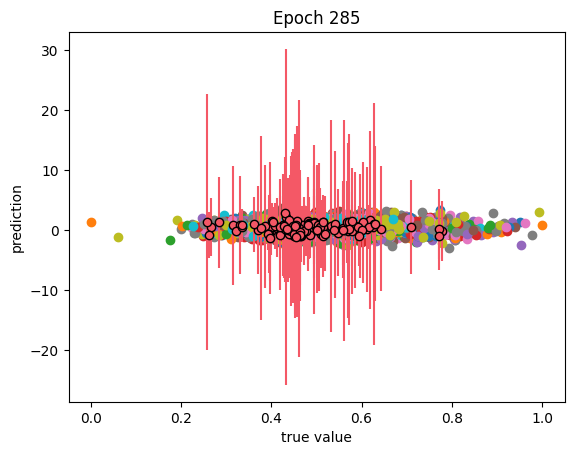

epoch 286 0.71
epoch 287 0.72
epoch 288 0.72
epoch 289 0.72
epoch 290 0.72


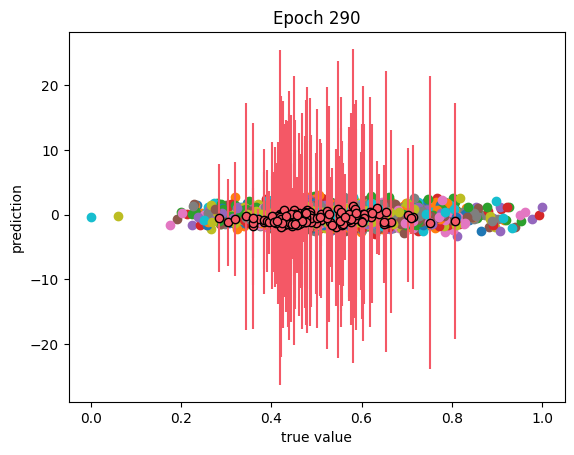

epoch 291 0.73
epoch 292 0.73
epoch 293 0.73
epoch 294 0.73
epoch 295 0.74


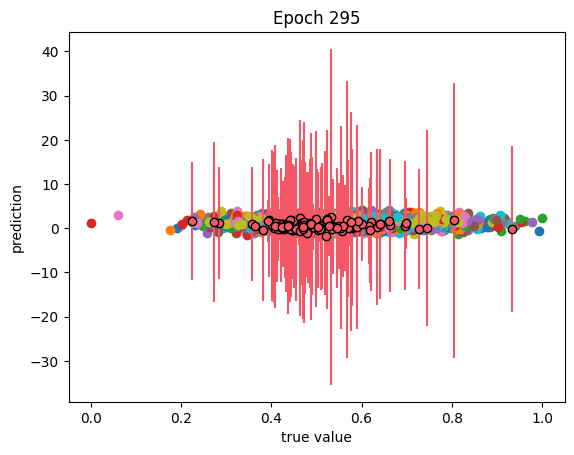

epoch 296 0.74
epoch 297 0.74
epoch 298 0.74
epoch 299 0.75
epoch 300 0.75


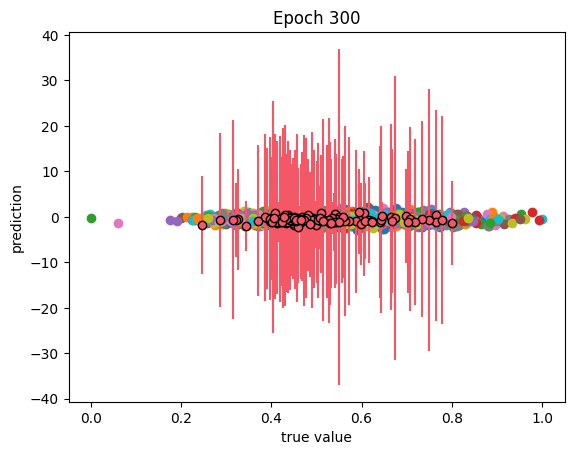

epoch 301 0.75
epoch 302 0.76
epoch 303 0.76
epoch 304 0.76
epoch 305 0.76


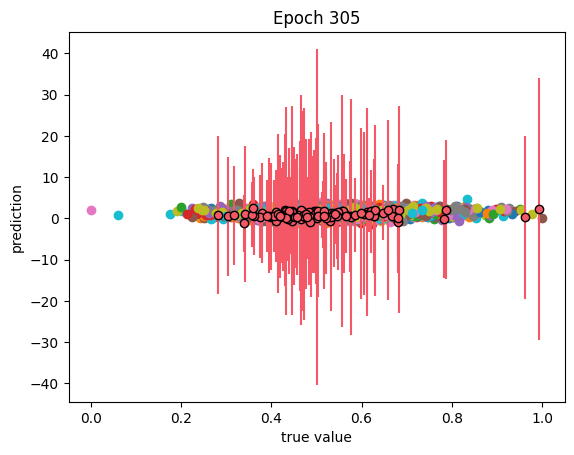

epoch 306 0.77
epoch 307 0.77
epoch 308 0.77
epoch 309 0.77
epoch 310 0.78


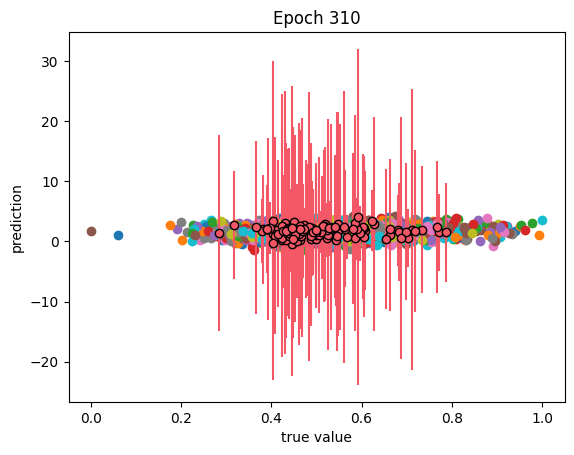

epoch 311 0.78
epoch 312 0.78
epoch 313 0.78
epoch 314 0.79
epoch 315 0.79


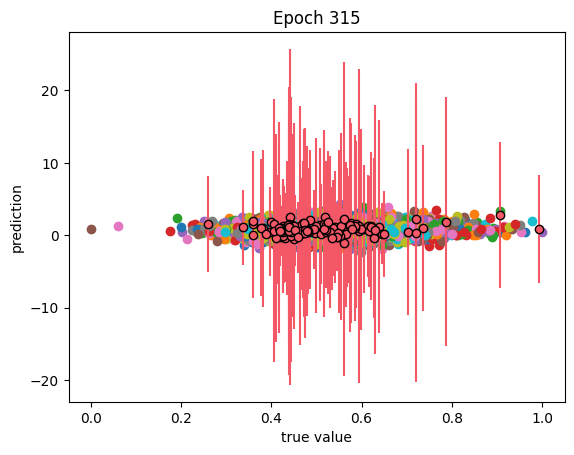

epoch 316 0.79
epoch 317 0.79
epoch 318 0.8
epoch 319 0.8
epoch 320 0.8


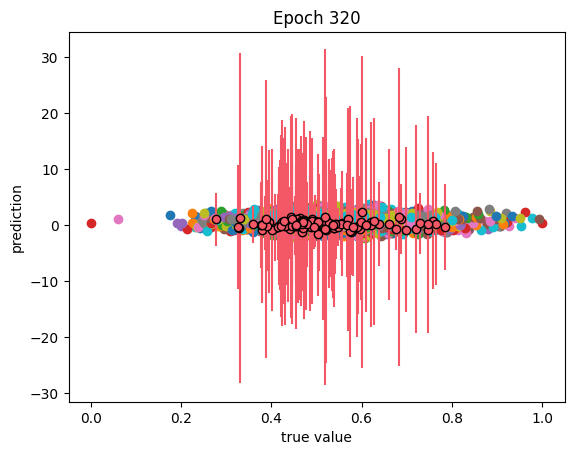

epoch 321 0.8
epoch 322 0.81
epoch 323 0.81
epoch 324 0.81
epoch 325 0.81


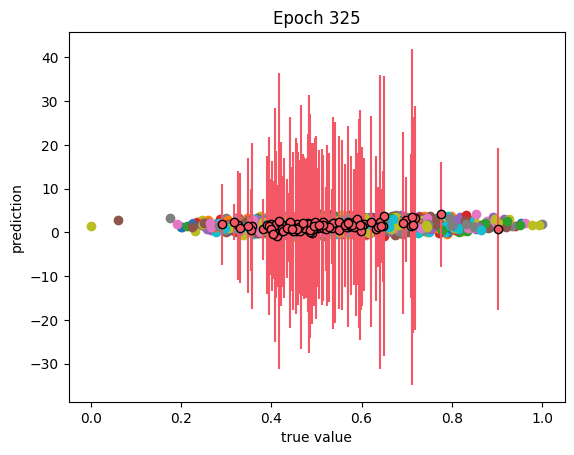

epoch 326 0.81
epoch 327 0.82
epoch 328 0.82
epoch 329 0.82
epoch 330 0.82


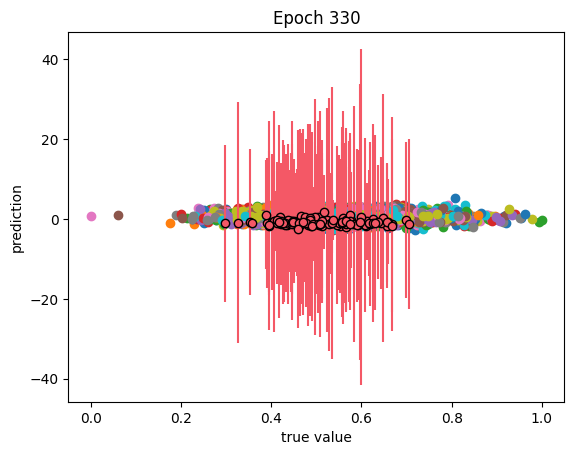

epoch 331 0.83
epoch 332 0.83
epoch 333 0.83
epoch 334 0.83
epoch 335 0.84


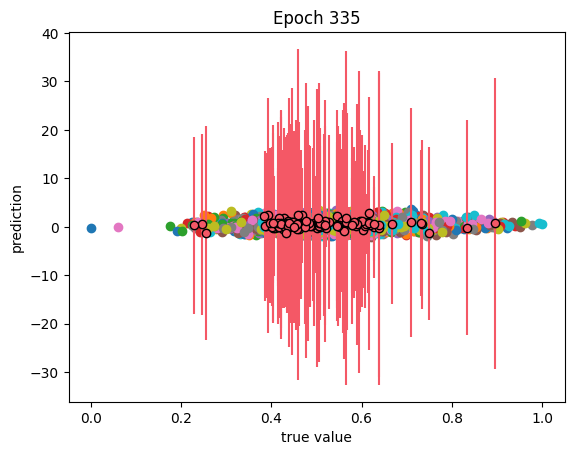

epoch 336 0.84
epoch 337 0.84
epoch 338 0.84
epoch 339 0.85
epoch 340 0.85


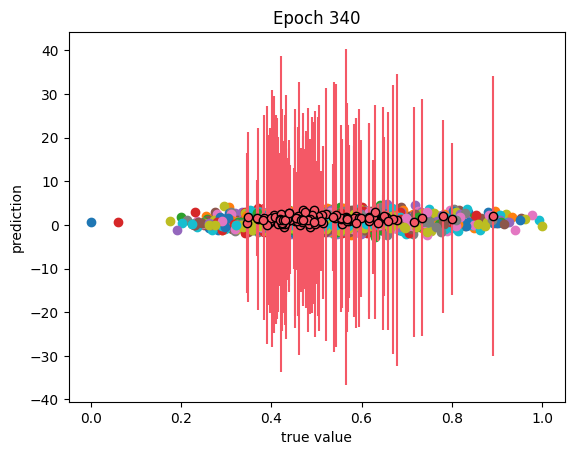

epoch 341 0.85
epoch 342 0.85
epoch 343 0.86
epoch 344 0.86
epoch 345 0.86


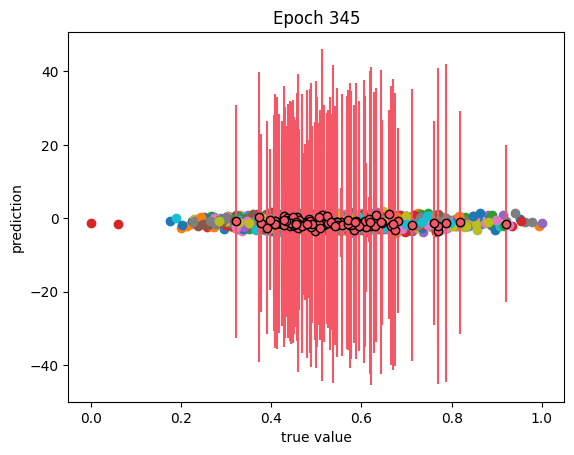

epoch 346 0.86
epoch 347 0.87
epoch 348 0.87
epoch 349 0.87
epoch 350 0.88


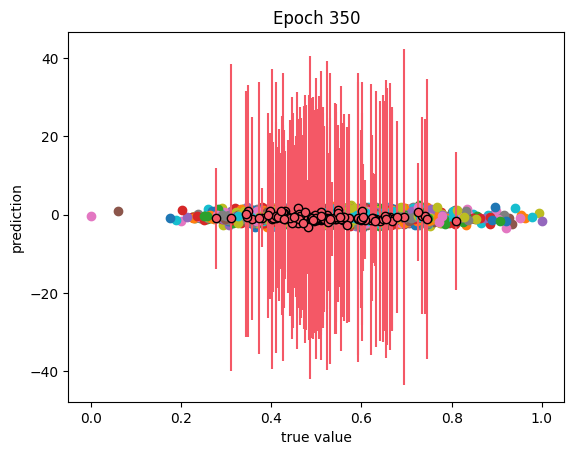

epoch 351 0.88
epoch 352 0.88
epoch 353 0.88
epoch 354 0.89
epoch 355 0.89


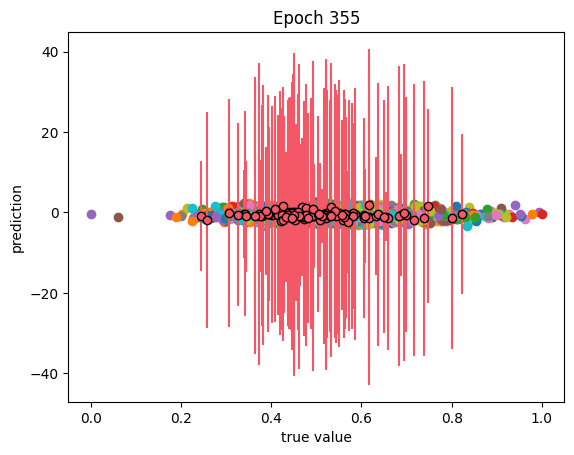

epoch 356 0.89
epoch 357 0.89
epoch 358 0.9
epoch 359 0.9
epoch 360 0.9


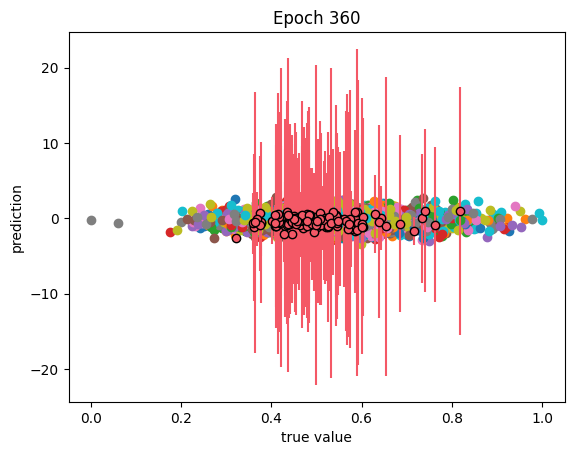

epoch 361 0.9
epoch 362 0.91
epoch 363 0.91
epoch 364 0.91
epoch 365 0.91


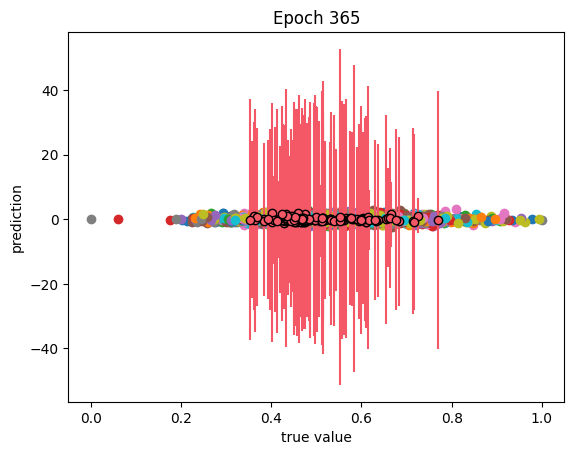

epoch 366 0.92
epoch 367 0.92
epoch 368 0.92
epoch 369 0.92
epoch 370 0.93


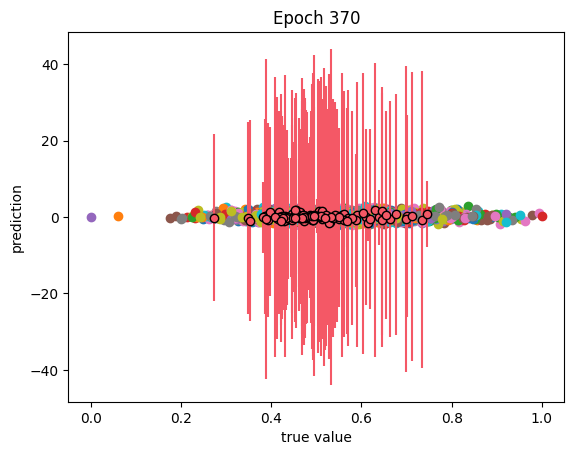

epoch 371 0.93
epoch 372 0.93
epoch 373 0.93
epoch 374 0.94
epoch 375 0.94


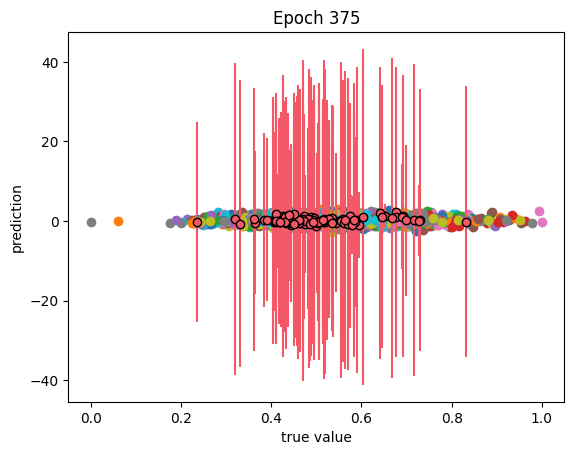

epoch 376 0.94
epoch 377 0.94
epoch 378 0.94
epoch 379 0.95
epoch 380 0.95


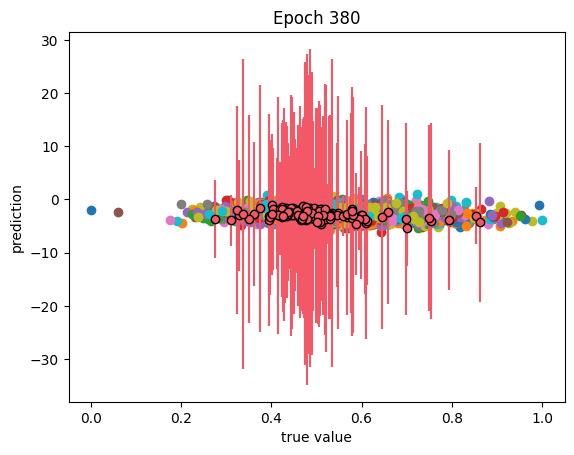

epoch 381 0.95
epoch 382 0.95
epoch 383 0.96
epoch 384 0.96
epoch 385 0.96


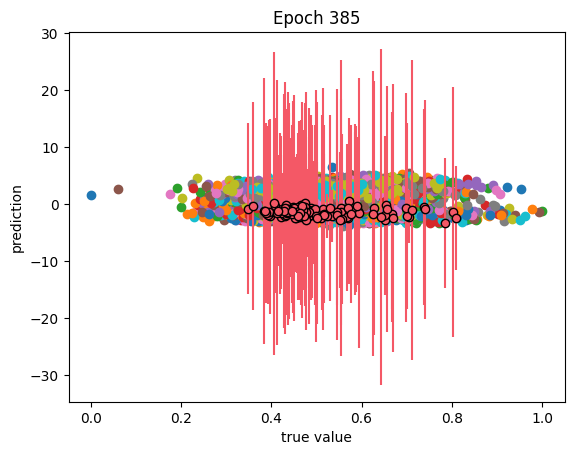

epoch 386 0.96
epoch 387 0.97
epoch 388 0.97
epoch 389 0.97
epoch 390 0.97


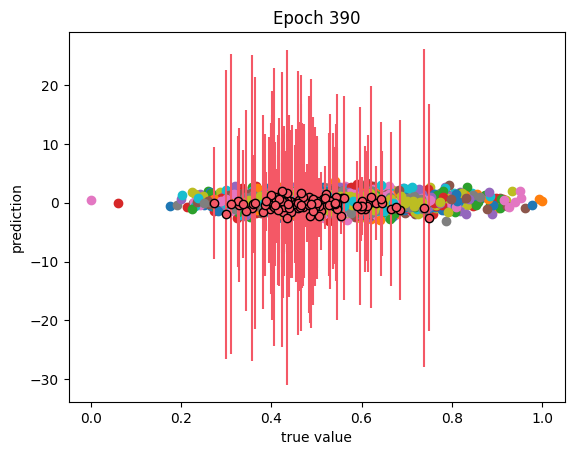

epoch 391 0.98
epoch 392 0.98
epoch 393 0.98
epoch 394 0.98
epoch 395 0.99


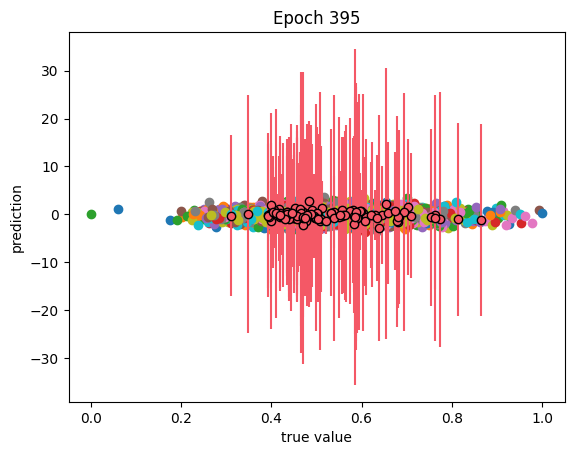

epoch 396 0.99
epoch 397 0.99
epoch 398 0.99
epoch 399 1.0
start at 1701191703.714896 end at 1701191758.4165728
54.70167684555054


<Figure size 640x480 with 0 Axes>

In [17]:
n_models = 1
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name='DE',
             EPOCHS=400,
             save_checkpoints=False,
             plot=True)
 

## Test the model
To run it through it's paces, generate a set of xs using the uniform draw and one set of (m, b, $\sigma$) values.

In [54]:
m_true = 1
b_true = 0
sigma_true = 1
# generate 10 datapoints
x_list = []
y_list = []
y_no_scatter = []
y_pred = []
y_pred_sigma = []
for i in range(100):
    x_true = rs.uniform(low=0, high = 100)
    x_list.append(x_true)
    thetas_1d_true = [x_true, m_true, b_true, sigma_true]
    y_list.append(simulator(thetas_1d_true))
    y_no_scatter.append(m_true * x_true + b_true)
    # now use the NN to make a prediction
    model = model_ensemble[0]
    model.eval()
    # first, normalize the x value using the xmin and xmax before
    '''
    norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
    norm_outputs = (ys - outputmin) / (outputmax - outputmin)
    '''
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)

    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    if np.shape(y_norm_pred) == (2,):
        y_pred.append((y_norm_pred[0]) * (outputmax - outputmin) + outputmin)
        y_pred_sigma.append(abs((y_norm_pred[1]) * (outputmax - outputmin) + outputmin))
    else:
        y_pred.append((y_norm_pred) * (outputmax - outputmin) + outputmin)
        y_pred_sigma.append(0)
    
    

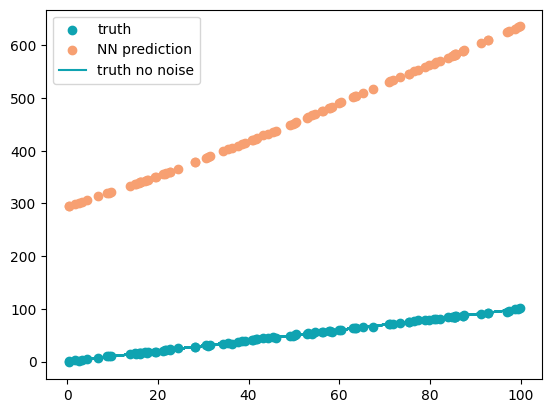

In [55]:
# plot
plt.clf()
plt.scatter(x_list, y_list, label = 'truth', color = '#0FA3B1')
plt.scatter(x_list, y_pred, label = 'NN prediction', color = '#F7A072')
#plt.errorbar(x_list, y_pred, yerr = y_pred_sigma, label = 'NN prediction', color = '#F7A072')

    
plt.plot(x_list, y_no_scatter, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
plt.show()


In [ ]:
# plot the "posterior" plot, which is gonna be a Gaussian
# for each individual data point
print(np.shape(x_val), np.shape(y_val))
print(x_val[0], y_val[0])
# is there a way to convert x_val[0][3] back to its true value?
# og_value = normal_value * (xmax - xmin) + xmin
og_xval = x_val[0] * (xmax - xmin) + xmin
print('og_xval', og_xval)
og_yval = y_val[0] * (ymax - ymin) + ymin
print('og_yval', og_yval)
STOP
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val[0]))
    print(y_pred)
    STOP
    y_pred_list.append(y_pred[:,0].detach().numpy())
    

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']
y_pred_list = []
for m in range(n_models):
    print(m)
    
        
    
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list.append(y_pred[:,0].detach().numpy())
    if m > 0:
        continue

    if loss_type == 'no_var_loss':
        plt.scatter(x_val[:,1], y_pred.detach().numpy(),
                label = 'predicted', s = 10, color = 'black')#color = color_list[m],
    else:
        plt.scatter(x_val[:,1], y_pred[:,0].detach().numpy(),
                label = f'predicted model {m}', color = 'black', ls = 'None')#color = color_list[m],
        plt.errorbar(x_val[:,1], y_pred[:,0].detach().numpy(),
                     yerr = abs(y_pred[:,1].detach().numpy()),
                label = f'predicted var model {m}', color = 'black', ls = 'None')#color = color_list[m],
    
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual', color = 'red', ls = 'None')

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

## Now epistemic error

In [ ]:
#print(y_pred_list)
#print(np.mean(y_pred_list, axis = 0))

plt.clf()
plt.scatter(x_val[:,1], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,1], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.scatter(x_val[:,3], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,3], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
plt.scatter(x_val[:,3], y_val, label = 'actual', color = 'red', s = 10)
#plt.errorbar(x_val[:,3], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('epsilon')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# there's gotta be a good way to plot the x and the y
plt.clf()

y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
# also go through and plot the error prop uncertainty given x_val
plt.clf()



y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black',
             label = 'prediction')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val,
             yerr = calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0'),
             color = 'red', ls = 'None', capsize = 5)


plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [ ]:
analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0')